In [26]:
import matplotlib
import dotenv
from pathlib import Path
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt



In [98]:
def basic_text_analysis(texts, dataset_name="dataset"):
    assert isinstance(texts, list)
    assert all(isinstance(t, str) for t in texts)

    def word_count(t):
        return len(t.split())

    def sentence_count(t):
        return len(re.findall(r'[.!?]+', t))

    data = {
        "char_len": [len(t) for t in texts],
        "word_count": [word_count(t) for t in texts],
        "sentence_count": [sentence_count(t) for t in texts],
    }

    df = pd.DataFrame(data)

    summary = {
        "dataset": dataset_name,
        "num_texts": len(texts),
        "char_len_mean": df.char_len.mean(),
        "char_len_median": df.char_len.median(),
        "word_count_mean": df.word_count.mean(),
        "word_count_median": df.word_count.median(),
        "sentence_count_mean": df.sentence_count.mean(),
    }

    return df, summary

In [105]:
def plot_distributions(df, dataset_name="dataset"):
    plt.figure()
    plt.hist(df["char_len"], bins=50)
    plt.title(f"Character Length Distribution — {dataset_name}")
    plt.xlabel("Characters")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure()
    plt.hist(df["word_count"], bins=20)
    plt.title(f"Word Count Distribution — {dataset_name}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure()
    plt.boxplot(df["word_count"])
    plt.title(f"Word Count Boxplot — {dataset_name}")
    plt.ylabel("Words")
    plt.show()


In [100]:
def get_data_summary(data: list, name:str):
    df, summary = basic_text_analysis(data, dataset_name=name)
    plot_distributions(df, dataset_name=name)

In [2]:
base_dir = Path.cwd()
data_dir = base_dir / "data"
ro_dir = data_dir / "judete"
mol_dir = data_dir / "raioane"

In [3]:
json_files = list(mol_dir.rglob('*.json'))

files = []
for file in json_files:
    files.append(file)
print(len(files))

6071


In [110]:
def sentence_splitter(text: str):
    SENT_END = r'(?<=[.!?。！？])\s+'
    sentences = re.split(SENT_END, text)

    return sentences

def clean_sentences(sentences: list):
    cleaned = []

    for s in sentences:
        text = s.replace("\n", " ").replace("\r", " ")
        text = re.sub(r"\s+", " ", text).strip()

        if len(text.split()) < 3: 
            continue

        if len(text.split()) > 20:
            continue

        if "foto" in text.lower().split() or "art" in text.lower().split():
            continue
        
        if not text[0].isupper():
            continue

        if text:
            cleaned.append(text)

    return cleaned

In [111]:
class Data:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = list(set(self.unpack_jsons()))

    def unpack_jsons(self):
        content = []
        json_files = list(self.root_dir.rglob('*.json'))

        for path in json_files:
            try:
                with open(path, 'r', encoding='utf-8') as f:
                    data = json.load(f)["content"]
                    sentences = sentence_splitter(data)
                    clean_sents = clean_sentences(sentences)
                    content.extend(clean_sents)
                    
            except json.JSONDecodeError:
                print(f"Skipping corrupt file: {path}")

        return content
    
    def get_splits(self, split:str):
        if split == "train":
            return self.files[:int(0.8 * len(self.files))]
        else:
            return self.files[int(0.8 * len(self.files)):]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        return self.files[idx]
    
    def __add__(self, other):
        combined = DataSet(self.root_dir)
        combined.files = self.files + other.files
        return combined


In [112]:
ro_data = Data(ro_dir)[:15000]
mol_data = Data(mol_dir)[:15000]

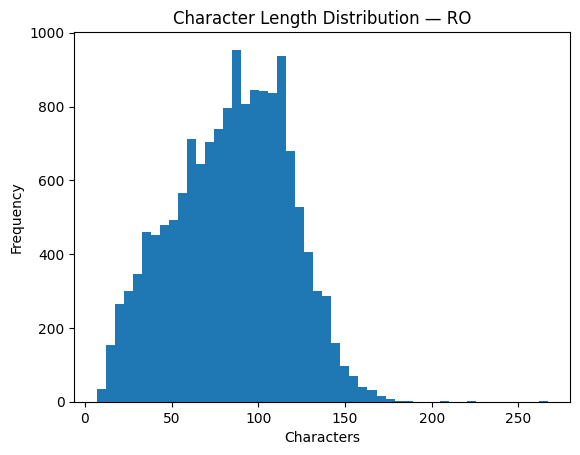

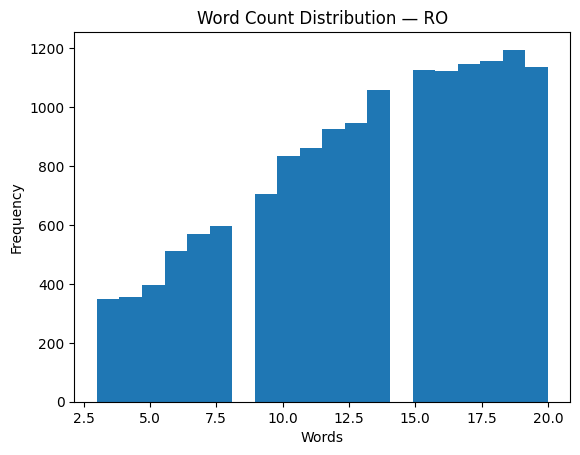

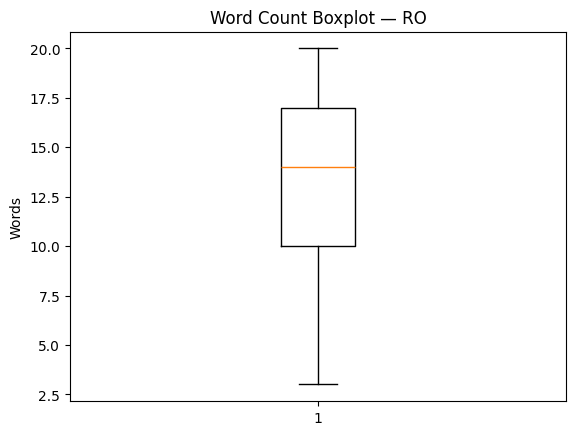

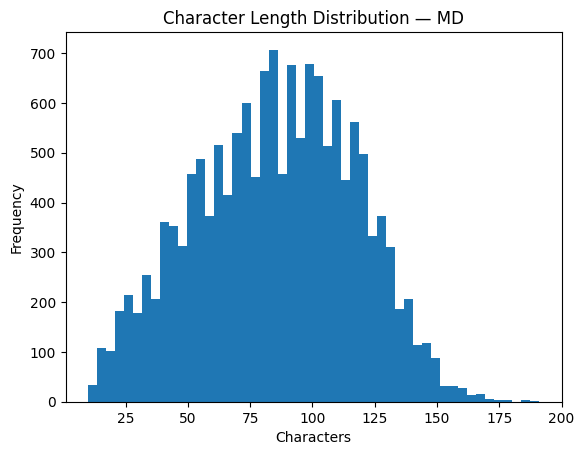

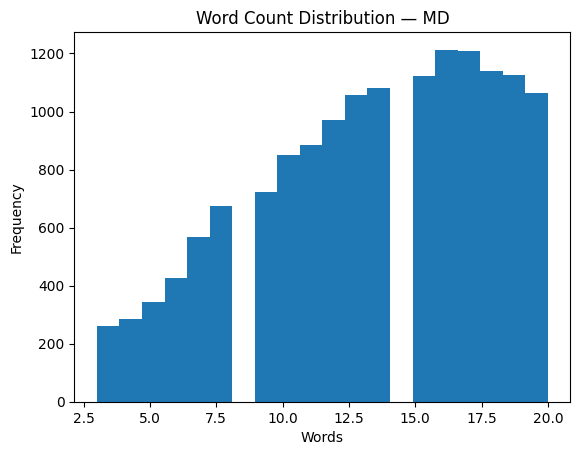

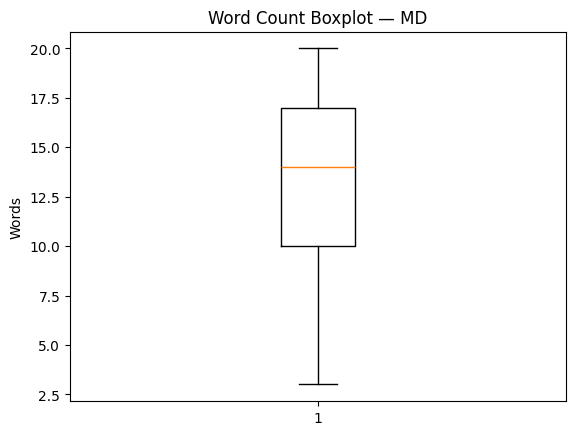

In [113]:
get_data_summary(ro_data, "RO")
get_data_summary(mol_data, "MD")

In [114]:
len(ro_data), len(mol_data)

(15000, 15000)

In [81]:
ro_data[73]

'Constantin Ene” al Județului Bacău, cu mijloacele tehnice destinate stingerii incendiilor, salvării persoanelor din medii ostile vieții și acordării primului ajutor calificat au intervenit la 1022 evenimente.'

In [115]:
with open("ro_source.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(ro_data))

In [116]:
with open("md_source.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(mol_data))